### Module submission group
- Group member 1
    - Name: Kartik Vora
    - Email: kav73@drexel.edu
- Group member 2
    - Name: Jerin Philip
    - Email: jp3839@drexel.edu
- Group member 3
    - Name: Mahima Modi
    - Email: mjm838@drexel.edu
- Group member 4
    - Name: Brinda Kulkarni
    - Email: bk644@drexel.edu
    
Using web-scraping techniques, we plan to acquire weather and accidents related information for New York.  We aim to highlight the link between weather conditions and road accident risk at an aggregate level , in order to improve road safety monitoring.According to the FHWA, most weather-related crashes happen on wet pavement (nearly 70 percent), while 46 percent of such accidents occur during rainfall, showing a clear relation between weather and accidents. Thus, we hope we can consolidate this data and make it easier to consume and distribute.

Data Sources:

NYC Open Data
*  https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

FDOT Open data Hub
*  https://gis-fdot.opendata.arcgis.com/datasets/crashes-all/explore?layer=0&location=27.398575%2C-83.000000%2C6.97&showTable=true

Virginia Accidents Data - 

*   https://www.virginiaroads.org/datasets/VDOT::crash-data-1/api?layer=0


Weather API : 
  * Documentation Link: https://openweathermap.org/history


Installing Libraries

In [1]:
!pip install selenium
!pip install sodapy
!pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached urllib3-1.26.9-py2.py3-none-any.whl (138 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.9
    Uninstalling urllib3-1.26.9:
      Successfully uni

Importing libraries

In [2]:
from bs4 import BeautifulSoup
import urllib
import requests 
import asyncio
import pandas as pd
import numpy as np
import math
import datetime
import os
from csv import writer
import datetime
from sodapy import Socrata
import matplotlib.pyplot as plt
import geopy

Import Selenium libraries required for Web Scraping

In [3]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

Creating/Append row to existing CSV

In [4]:
def append_to_csv(csvFileName, elementsToAppend):
    # open the csv file in the append mode
    with open(csvFileName, 'a+', newline='') as append_obj:
        # created a writer object from the writer module
        append_writer = writer(append_obj)
        # the created writer object which writes new row to the csv
        append_writer.writerow(elementsToAppend)

Function to add car_crash_location

In [36]:
def add_carsh_location(crash_df):
  
 
  # Initialize Nominatim API
  geolocator = Nominatim(user_agent="geoapiExercises")
  

  for i,row in crash_df.iterrows():
      Latitude,Longitude = row['Latitude'], row['Longitude']

      try:
          location = geolocator.geocode(str(Latitude)+","+str(Longitude))

          print(location.raw['display_name'])
          loc_data = location.raw['display_name'].split(', ')
  
          zcode = int(loc_data[-2])
          crash_df.loc[i,['zipcode']] = zcode
      except:
          print("lat and long",row['Latitude'], row['Longitude'])
  return crash_df
  

In [6]:
if os.path.exists('weather.csv'):
  df_weather = pd.read_csv('weather.csv')
else:
  df_weather = pd.DataFrame(columns=['timestamp', 'longitude','latitude', 'cloudiness', 'temperature', 'feels_like', 'pressure', 'humidity', 'wind_deg', 'wind_speed', 'rain', 'weather_desc'])
  df_weather.to_csv('weather.csv',index = False)

Function to call weather API 

This function requires latitude, longitude and timestamp to request for weather data. It caches the response in weather.csv file, so that for future use, data can simply be obtained from it instead of calling the API again

In [7]:
def get_weather_data(api_key,time,lat,lng):
  # need to add code if data for that time, lat, long already exists in dataframe
  query = df_weather.loc[((df_weather["timestamp"]==int(time))&(df_weather["longitude"]==float(lng))&(df_weather["latitude"]==float(lat)))]
  if len(query.values) !=0:

    details =  {
    'cloudiness': query['cloudiness'].values[0],
    'temperature': query['temperature'].values[0],
    'feels_like': query['feels_like'].values[0],
    'pressure': query['pressure'].values[0],
    'humidity': query['humidity'].values[0],
    'wind_deg': query['wind_deg'].values[0],
    'wind_speed': query['wind_speed'].values[0],
    'rain': query['rain'].values[0] ,
    'weather_desc' : query['weather_desc'].values[0]
    }
    
  else:
    address = "http://history.openweathermap.org/data/2.5/history/city?lat="+str(lat)+"&lon="+str(lng)+"&type=hour&start="+str(time)+"&cnt=1&appid=" + api_key
    resp = requests.get(address)
    result = resp.json()
    
    if 'list' in result:
      cloudiness = result['list'][0]['clouds']['all'] if "clouds" in result['list'][0] else 0
      temperature = result['list'][0]['main']['temp'] if "main" in result['list'][0] else 0
      feels_like = result['list'][0]['main']['feels_like'] if "main" in result['list'][0] else 0
      pressure = result['list'][0]['main']['pressure'] if "main" in result['list'][0] else 0
      humidity = result['list'][0]['main']['humidity'] if "main" in result['list'][0] else 0
      wind_deg = result['list'][0]['wind']['deg'] if "wind" in result['list'][0] else 0
      wind_speed = result['list'][0]['wind']['speed'] if "wind" in result['list'][0] else 0
      rain = result['list'][0]['rain']['1h'] if "rain" in result['list'][0] else 0
      weather_desc = result['list'][0]['weather'][0]['description'] if "weather" in result['list'][0] else NA 
      details =  {
      'cloudiness': cloudiness,
      'temperature': temperature,
      'feels_like': feels_like,
      'pressure': pressure,
      'humidity': humidity,
      'wind_deg': wind_deg,
      'wind_speed': wind_speed,
      'rain': rain ,
      'weather_desc' : weather_desc
      }
      # append new data to weather.csv so that next time no need to call api
      newrow = [time,  lng,  lat, cloudiness, temperature, feels_like, pressure, humidity, wind_deg, wind_speed, rain, weather_desc]
      append_to_csv('weather.csv', newrow)
    else:
      newrow = [time,  lng,  lat, 0, 0, 0, 0, 0, 0, 0, 0, "NA"]
      append_to_csv('weather.csv', newrow)
      details = None 
  return details

Function to save Dataframe to .csv

In [8]:
def save_dataframe_to_csv(df, filepath):  
  df.to_csv(filepath, index = False)  


Merge all the data from NYC, Virginia and Florida into a single Dataframe

In [34]:
def merge_all_dataframes():

  nyc_df = pd.read_csv('nyc_weather.csv')
  virginia_df = pd.read_csv("virginia_accidents_weather.csv")
  florida_df = pd.read_csv("florida_accidents_weather.csv")

  crash_columns = ['CRASH_DT', 'Latitude','Longitude' ,'cloudiness', 'temperature',
        'feels_like', 'pressure', 'humidity', 'wind_deg', 'wind_speed', 'rain',
        'weather_desc','LOCATION']

  nyc_columns = ['crash_datetime','latitude', 'longitude', 'cloudiness', 'temperature',
       'feels_like', 'pressure', 'humidity', 'wind_deg', 'wind_speed', 'rain',
       'weather_desc']
  nyc_df = nyc_df[nyc_columns]
  nyc_df['LOCATION'] = 'NYC'
  nyc_df.columns = crash_columns

  virginia_columns = ['CRASH_DT', 'LAT','LONG', 'cloudiness', 'temperature',
       'feels_like', 'pressure', 'humidity', 'wind_deg', 'wind_speed', 'rain',
       'weather_desc','LOCATION']

  virginia_df = virginia_df[virginia_columns]
  virginia_df.columns = crash_columns

  florida_columns = ['CRASH_DT', 'LAT','LONG', 'cloudiness', 'temperature',
       'feels_like', 'pressure', 'humidity', 'wind_deg', 'wind_speed', 'rain',
       'weather_desc','LOCATION']

  florida_df = florida_df[florida_columns]
  florida_df.columns = crash_columns

  crash_df = pd.concat([florida_df, virginia_df,nyc_df], ignore_index=True)
  crash_df['CRASH_DATE'] = [datetime.datetime.fromtimestamp(dt) for dt in crash_df.CRASH_DT.values]

  crash_df['DOW'] = crash_df['CRASH_DATE'].dt.dayofweek
  crash_df['Hour'] = crash_df['CRASH_DATE'].dt.hour
  print("Data Merged.")
  save_dataframe_to_csv(crash_df, "accidents_weather.csv")
  return crash_df

All URLs/API details required to fetch the data

In [10]:
nyc_url = 'https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95'
nyc_app_token="uTiJmqGXfJhlkDskjEHLDvsha"
virginia_url = 'https://services.arcgis.com/p5v98VHDX9Atv3l7/arcgis/rest/services/CrashData_test/FeatureServer/0/query?where=CRASH_YEAR%20%3D%20\'2021\'%20OR%20CRASH_YEAR%20%3D%20\'2022\'&outFields=DOCUMENT_NBR,CRASH_DT,CRASH_MILITARY_TM,CRASH_SEVERITY,PERSONS_INJURED,PEDESTRIANS_KILLED,PEDESTRIANS_INJURED,VEH_COUNT,COLLISION_TYPE,LIGHT_CONDITION,RD_TYPE,ROADWAY_SURFACE_COND,RELATION_TO_ROADWAY,ROADWAY_ALIGNMENT,ROADWAY_SURFACE_TYPE,ROADWAY_DEFECT,ROADWAY_DESCRIPTION,INTERSECTION_TYPE,CRASH_YEAR&outSR=4326&f=json'
florida_url = 'https://gis.fdot.gov/arcgis/rest/services/Crashes_All/FeatureServer/0/query?f=json&where=1%3D1&outFields=*&returnGeometry=false&orderByFields=CALENDAR_YEAR%20desc&resultOffset=0&resultRecordCount=2000'
api_key = '97f5888ee681302785267559cfd1d433'#'3b95598e42d970a238054a27979d907a'
florida_site_url ='https://gis-fdot.opendata.arcgis.com/datasets/crashes-all/explore?layer=0&location=27.368543%2C-83.000000%2C6.97&showTable=true'

NYC Data obtained used Selenium (Only works in Jupyter Notebook and needs to install chromedrive before using this)

In [11]:
'''def get_nyc_data_using_selenium():
  ### Download cromedriver before using this 
  driver = webdriver.Chrome('./chromedriver_win32/chromedriver')
  url = "https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95"
  driver.get(url)
  print(driver.current_url)
  from requests_html import AsyncHTMLSession 
  asession = AsyncHTMLSession()
  r = await asession.get(url)
  await r.html.arender()
  resp=r.html.raw_html
  header = driver.find_elements_by_xpath ("//html/body/main/div/div[1]/div/div[3]/section[3]/div[2]/div/div/div[4]/div[1]/div/table/thead/tr["+str(1)+"]/th")
  columns = []
  for j in range(len(header)):
      r=driver.find_elements_by_xpath ("//html/body/main/div/div[1]/div/div[3]/section[3]/div[2]/div/div/div[4]/div[1]/div/table/thead/tr["+str(1)+"]/th["+str(j)+"]")
      if len(r)>0:
          columns.append(r[0].text)
  list2=[]
  # for pg in range(1,20):
  cnt=0
  pg = 1
  TOTAL_Pg = 866
  while pg<TOTAL_Pg:
      try:
          print("We are on page:",pg)
          for i in range(1,15):
              list1=[]
              n=driver.find_elements_by_xpath ("//html/body/main/div/div[1]/div/div[3]/section[3]/div[2]/div/div/div[4]/div[1]/div/table/tbody/tr["+str(i)+"]/td")
              for j in range(len(n)):
                  r=driver.find_elements_by_xpath ("//html/body/main/div/div[1]/div/div[3]/section[3]/div[2]/div/div/div[4]/div[1]/div/table/tbody/tr["+str(i)+"]/td["+str(j)+"]")
                  if len(r)>0:
                      list1.append(r[0].text)
              list2.append(list1)
          WebDriverWait(driver,250).until(EC.element_to_be_clickable((By.XPATH,"//button[@class='pager-button-next']"))).click()
          pg+=1
      except:
          cnt+=1
          print("ReTrying")
      import pandas as pd
  df19=pd.DataFrame(list2, columns=columns)
  df19.to_csv('NYC_data.csv')
  return df19'''

'def get_nyc_data_using_selenium():\n  ### Download cromedriver before using this \n  driver = webdriver.Chrome(\'./chromedriver_win32/chromedriver\')\n  url = "https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95"\n  driver.get(url)\n  print(driver.current_url)\n  from requests_html import AsyncHTMLSession \n  asession = AsyncHTMLSession()\n  r = await asession.get(url)\n  await r.html.arender()\n  resp=r.html.raw_html\n  header = driver.find_elements_by_xpath ("//html/body/main/div/div[1]/div/div[3]/section[3]/div[2]/div/div/div[4]/div[1]/div/table/thead/tr["+str(1)+"]/th")\n  columns = []\n  for j in range(len(header)):\n      r=driver.find_elements_by_xpath ("//html/body/main/div/div[1]/div/div[3]/section[3]/div[2]/div/div/div[4]/div[1]/div/table/thead/tr["+str(1)+"]/th["+str(j)+"]")\n      if len(r)>0:\n          columns.append(r[0].text)\n  list2=[]\n  # for pg in range(1,20):\n  cnt=0\n  pg = 1\n  TOTAL_Pg = 866\n  while pg<TOTAL_Pg:\n      try:

Collecting Data for NYC - Getting the Data from API

In [12]:
def get_nyc_data_using_api(url):
  client = Socrata("data.cityofnewyork.us", app_token="uTiJmqGXfJhlkDskjEHLDvsha")
  results = client.get("h9gi-nx95", limit=50000)

  # Convert to pandas  
  df = pd.DataFrame.from_records(results)
  df['LOCATION'] ="NYC"
  save_dataframe_to_csv(df,'nyc_accidents.csv')
  return df

In [13]:
#df = get_nyc_data_using_api(nyc_url)

Preprocessing of NYC Data - making it ready for Weather API call

In [14]:
def clean_nyc_data(df):
  df['crash_date'] = pd.to_datetime(df['crash_date']).dt.date
  df['crash_time'] = pd.to_datetime(df['crash_time']).dt.time
  df['crash_datetime'] = pd.to_datetime(df.crash_date.astype(str) + ' ' + df.crash_time.astype(str)).astype(np.int64) // 10**9
  df = df[(df['crash_date'] > (datetime.date.today() - datetime.timedelta(days=365)))]
  df= df[df.latitude.notna()|df.latitude !=0]
  return df
  

Merge the cleaned data with weather data and save it in a csv file

In [15]:
def merge_weather_accident_nyc(df):
  for idx, row in df.iterrows():
        if  df.loc[idx,'latitude'] and df.loc[idx,'longitude']:
          weather_details = get_weather_data(api_key,df.loc[idx,'crash_datetime'],df.loc[idx,'latitude'],df.loc[idx,'longitude'])
          if weather_details:
            df.loc[idx,"cloudiness"] = weather_details['cloudiness']
            df.loc[idx,"temperature"] = weather_details['temperature']
            df.loc[idx,"feels_like"] = weather_details['feels_like']
            df.loc[idx,"pressure"] = weather_details['pressure']
            df.loc[idx,"humidity"] = weather_details['humidity']
            df.loc[idx,"wind_deg"] = weather_details['wind_deg']
            df.loc[idx,"wind_speed"] = weather_details['wind_speed']
            df.loc[idx,"rain"] = weather_details['rain']
            df.loc[idx,"weather_desc"] = weather_details['weather_desc']
  save_dataframe_to_csv(df,'nyc_weather.csv')
  return df

Getting the Virginia Accidents Data using API

In [16]:
def get_virginia_data_using_api(virginia_url):
  data = requests.get(virginia_url).json()
  column_names = ["CRASH_DT", "CRASH_YEAR", "LIGHT_CONDITION","LAT","LONG","LOCATION"]
  df = pd.DataFrame(columns = column_names)
  for i in range(len(data['features'])):
    crash_date = int(data['features'][i]['attributes']["CRASH_DT"])//1000
    crash_year = data['features'][i]['attributes']["CRASH_YEAR"]
    light_condition = data['features'][i]['attributes']["LIGHT_CONDITION"]
    lng = data['features'][i]['geometry']['x']
    lat = data['features'][1]['geometry']['y']
    df.loc[i] = [crash_date,crash_year,light_condition,lat,lng,"Virginia"]
  save_dataframe_to_csv(df,'virginia_accidents.csv')
  return df

Preprocessing Virginia data and making it ready for calling weather API

In [17]:
def clean_virginia_data(df):
  # the crash_date in milliseconds, need to divide it by 1000
  df["CRASH_DATE"]=[datetime.datetime.fromtimestamp(dt) for dt in df.CRASH_DT.values]
  df = df[(df['CRASH_DATE'] > np.datetime64('2021-06-05'))]
  
  return df

Calling the weather API and merging with the accidents Data

In [18]:
def merge_weather_accident_virginia(df) :
  for idx, row in df.iterrows():
        if  df.loc[idx,'LAT'] and df.loc[idx,'LONG']:
          weather_details = get_weather_data(api_key,str(df.loc[idx,'CRASH_DT']),df.loc[idx,'LAT'],df.loc[idx,'LONG'])
          if weather_details:
            df.loc[idx,"cloudiness"] = weather_details['cloudiness']
            df.loc[idx,"temperature"] = weather_details['temperature']
            df.loc[idx,"feels_like"] = weather_details['feels_like']
            df.loc[idx,"pressure"] = weather_details['pressure']
            df.loc[idx,"humidity"] = weather_details['humidity']
            df.loc[idx,"wind_deg"] = weather_details['wind_deg']
            df.loc[idx,"wind_speed"] = weather_details['wind_speed']
            df.loc[idx,"rain"] = weather_details['rain']
            df.loc[idx,"weather_desc"] = weather_details['weather_desc']
  save_dataframe_to_csv(df,'virginia_accidents_weather.csv')
  return df

Get Florida Data by calling its AJAX Query obtained from Inspecting the website and checking the AJAX call in Network

In [19]:
def get_florida_data_using_query(url):
  data = requests.get(url).json()
  column_names = ["CRASH_DT", "CRASH_YEAR", "AGGRESSIVE_DRIVING_IND","LAT","LONG","LOCATION"]
  df = pd.DataFrame(columns = column_names)
  for i in range(len(data['features'])):
    crash_date = int(data['features'][i]['attributes']["CRASH_DATE"])//1000
    crash_year = data['features'][i]['attributes']["CALENDAR_YEAR"]
    agg_driving_ind = data['features'][i]['attributes']["AGGRESSIVE_DRIVING_IND"]
    lng = data['features'][i]['attributes']['LONGITUDE']
    lat = data['features'][1]['attributes']['LATITUDE']
    df.loc[i] = [crash_date,crash_year,agg_driving_ind,lat,lng,"Florida"]
  save_dataframe_to_csv(df,'florida_accidents.csv')
  return df

Preprocessing Data for making it ready for weather API call

In [20]:
def clean_florida_data(df):
  # the crash_date in milliseconds, need to divide it by 1000
  df["CRASH_DATE"]=[datetime.datetime.fromtimestamp(dt) for dt in df.CRASH_DT.values]
  df = df[((df['CRASH_DATE'] > (np.datetime64('today', 'D') - np.timedelta64(365, 'D'))) | (df['AGGRESSIVE_DRIVING_IND'] =="N"))]
  
  return df

Merging accidents and Weather Data

In [21]:
def merge_weather_accident_florida(df):
  for idx, row in df.iterrows():
        if  df.loc[idx,'LAT'] and df.loc[idx,'LONG']:
          weather_details = get_weather_data(api_key,str(df.loc[idx,'CRASH_DT']),df.loc[idx,'LAT'],df.loc[idx,'LONG'])
          if weather_details:
            df.loc[idx,"cloudiness"] = weather_details['cloudiness']
            df.loc[idx,"temperature"] = weather_details['temperature']
            df.loc[idx,"feels_like"] = weather_details['feels_like']
            df.loc[idx,"pressure"] = weather_details['pressure']
            df.loc[idx,"humidity"] = weather_details['humidity']
            df.loc[idx,"wind_deg"] = weather_details['wind_deg']
            df.loc[idx,"wind_speed"] = weather_details['wind_speed']
            df.loc[idx,"rain"] = weather_details['rain']
            df.loc[idx,"weather_desc"] = weather_details['weather_desc']
  save_dataframe_to_csv(df,'florida_accidents_weather.csv')
  return df

Gathering all data and then Merging to Single DataFrame

In [22]:
def create_accident_weather_data():
  # Creating Florida Data
  df = get_florida_data_using_query(florida_url)
  cleaned_df = clean_florida_data(df)
  df_florida = merge_weather_accident_florida(cleaned_df)
  print("Florida Data is ready.")

  # Creating Virginia Data
  df = get_virginia_data_using_api(virginia_url)
  cleaned_df = clean_virginia_data(df)
  df_virginia = merge_weather_accident_virginia(cleaned_df)
  print("Virginia Data is ready.")

  # Creating NYC Data
  df = get_nyc_data_using_api(nyc_url)
  cleaned_df = clean_nyc_data(df)
  df_nyc = merge_weather_accident_nyc(cleaned_df)
  print("NYC Data is ready.")  
  
  return df


In [ ]:
df = create_accident_weather_data()

Final Data Set

In [ ]:
print("Now Merging all the data.")
crash_df = merge_all_dataframes()
df_final = add_carsh_location(crash_df)


In [40]:
save_dataframe_to_csv(df_final,'accidents_weather.csv')

Sample data

In [38]:
df_final.head()

,CRASH_DT,Latitude,Longitude,cloudiness,temperature,feels_like,pressure,humidity,wind_deg,wind_speed,rain,weather_desc,LOCATION,CRASH_DATE,DOW,Hour,zipcode
0,1650153600,29.658049,-82.251173,40.0,299.56,299.56,1014.0,70.0,0.0,0.00,0.0,scattered clouds,Florida,2022-04-17,6,0,32609.0
1,1650067200,29.658049,-82.419410,40.0,296.29,296.44,1019.0,68.0,50.0,4.63,0.0,scattered clouds,Florida,2022-04-16,5,0,32607.0
2,1652832000,29.658049,-81.958554,72.0,301.11,303.74,1013.0,70.0,171.0,1.80,0.0,broken clouds,Florida,2022-05-18,2,0,NaN
3,1651622400,29.658049,-81.576383,97.0,299.19,299.19,1007.0,64.0,114.0,2.87,0.0,overcast clouds,Florida,2022-05-04,2,0,32131.0
4,1650931200,29.658049,-81.809890,13.0,297.92,298.05,1018.0,61.0,78.0,0.45,0.0,few clouds,Florida,2022-04-26,1,0,32147.0


In [43]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CRASH_DT      8523 non-null   int64         
 1   Latitude      8523 non-null   float64       
 2   Longitude     8523 non-null   float64       
 3   cloudiness    8144 non-null   float64       
 4   temperature   8144 non-null   float64       
 5   feels_like    8144 non-null   float64       
 6   pressure      8144 non-null   float64       
 7   humidity      8144 non-null   float64       
 8   wind_deg      8144 non-null   float64       
 9   wind_speed    8144 non-null   float64       
 10  rain          8144 non-null   float64       
 11  weather_desc  8144 non-null   object        
 12  LOCATION      8523 non-null   object        
 13  CRASH_DATE    8523 non-null   datetime64[ns]
 14  DOW           8523 non-null   int64         
 15  Hour          8523 non-null   int64   

High Level Analysis of our Data

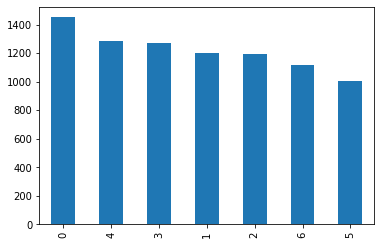

In [41]:
fig, ax = plt.subplots()
df_final['DOW'].value_counts().plot(ax=ax, kind='bar')

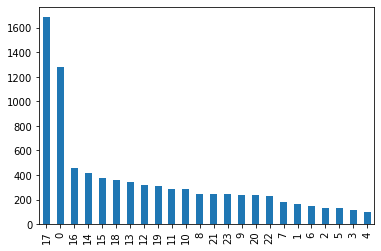

In [42]:
fig, ax = plt.subplots()
df_final['Hour'].value_counts().plot(ax=ax, kind='bar')